# Local maxima detection
For detecting local maxima, pixels surrounded by pixels with lower intensity, we can use some functions in [scikit-image](https://scikit-image.org) and [clesperanto](https://github.com/clEsperanto/pyclesperanto_prototype).

See also
* [Finding local maxima (scikit-image tutorial)](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_peak_local_max.html)

In [1]:
from skimage.feature import peak_local_max
import pyclesperanto_prototype as cle
from skimage.io import imread, imshow
from skimage.filters import gaussian 
import matplotlib.pyplot as plt

We start by loading an image and cropping a region for demonstration purposes. We used image set [BBBC007v1](https://bbbc.broadinstitute.org/BBBC007) image set version 1 (Jones et al., Proc. ICCV Workshop on Computer Vision for Biomedical Image Applications, 2005), available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012].

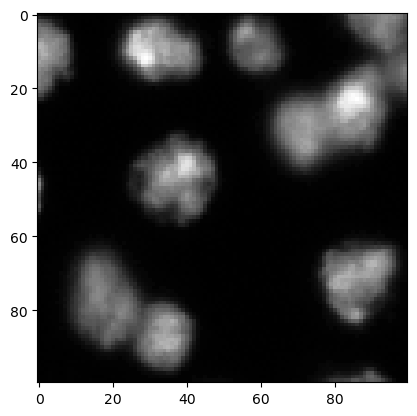

In [2]:
image = imread("../../data/BBBC007_batch/A9 p7d.tif")[-100:, 0:100]

cle.imshow(image)

## Preprocessing
A common preprocessing step before detecting maxima is blurring the image. This makes sense to avoid detecting maxima that are just intensity variations resulting from noise.

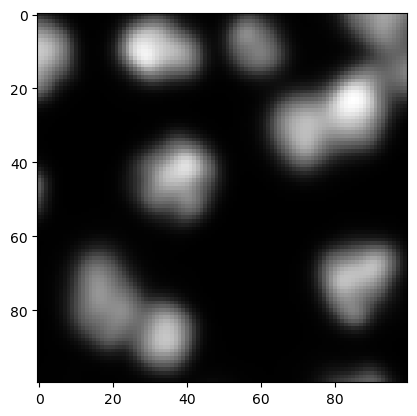

In [3]:
preprocessed = gaussian(image, sigma=2, preserve_range=True)

cle.imshow(preprocessed)

## peak_local_max
The [`peak_local_max` function](https://scikit-image.org/docs/stable/api/skimage.feature.html?highlight=peak_local_max#skimage.feature.peak_local_max) allows detecting maxima which have higher intensity than surrounding pixels and other maxima according to a defined threshold.

In [4]:
coordinates = peak_local_max(preprocessed, threshold_abs=5)
coordinates

array([[23, 85],
       [11, 29],
       [41, 40],
       [88, 34],
       [72, 83],
       [69, 89],
       [31, 72],
       [75, 16],
       [80, 22],
       [ 6, 56]], dtype=int64)

These coordinates can be visualized using matplotlib's plot function.

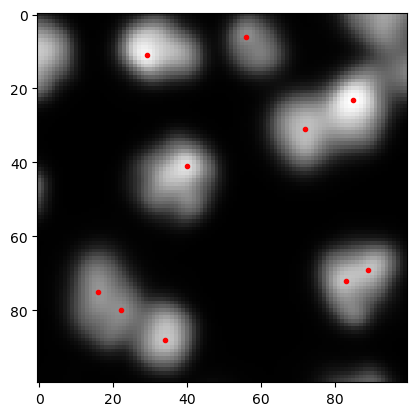

In [5]:
cle.imshow(preprocessed, continue_drawing=True)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

If there are too many maxima detected, one can modify the results by changing the `sigma` parameter of the Gaussian blur above or by changing the threshold passed to the `peak_local_max` function.

## detect_maxima_box

The function `peak_local_max` tends to take long time, e.g. when processing large 3D image data. Thus, an alternaive shall be introduced: clesperanto's `detect_maxima_box` is an image filter that sets pixels to value `1` in case surrounding pixels have lower intensity. It typically performs fast also on large 3D image data.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
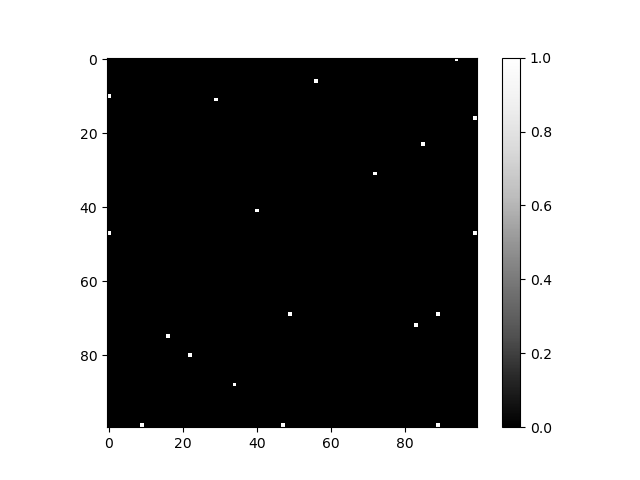
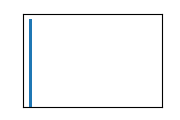

In [6]:
local_maxima_image = cle.detect_maxima_box(preprocessed)
local_maxima_image

Obviously, it results in a binary image. This binary image can be converted to a label image by labeling individual spots with different numbers. From this label image, we can remove maxima detected at image borders, which might be useful in this case.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
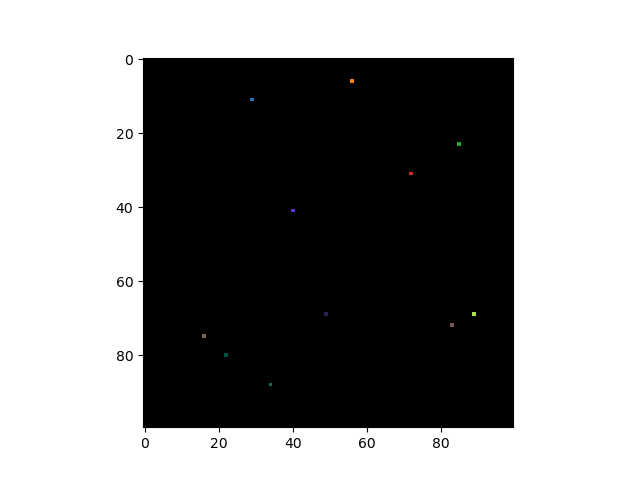

In [7]:
all_labeled_spots = cle.label_spots(local_maxima_image)

labeled_spots = cle.exclude_labels_on_edges(all_labeled_spots)
labeled_spots

To visualize these spots on the original image, it might make sense to increase the size of the spots - just for visualization purposes.

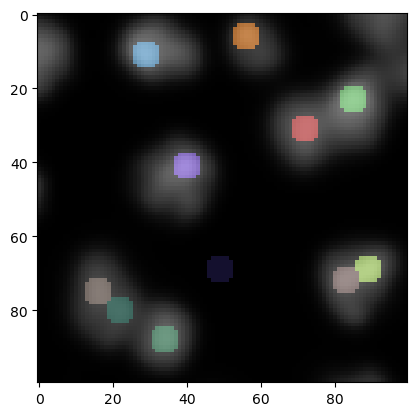

In [8]:
label_visualization = cle.dilate_labels(labeled_spots, radius=3)

cle.imshow(preprocessed, continue_drawing=True)
cle.imshow(label_visualization, labels=True, alpha=0.5)

In the lower center of this image we see now a local maximum that has been detected in the background. We can remove those maxima in lower intensity regions by thresholding.

cl.OCLArray([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
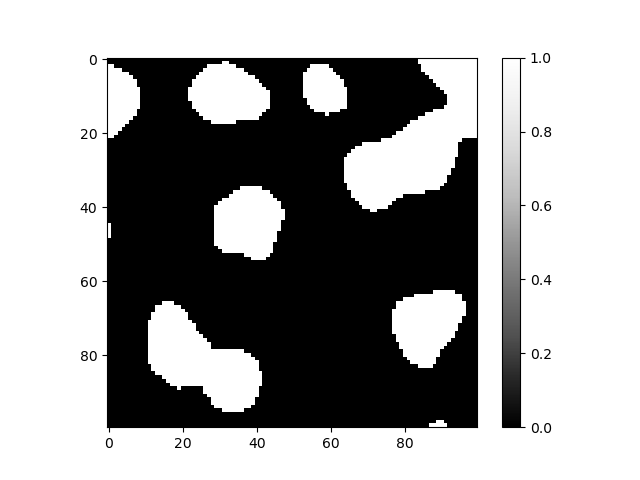
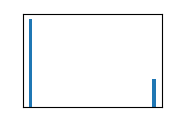

In [9]:
binary_image = cle.threshold_otsu(preprocessed)
binary_image

We can now exclude labels from the spots image where the intensity in the binary image is not within range `[1..1]` (i.e. exactly 1).

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
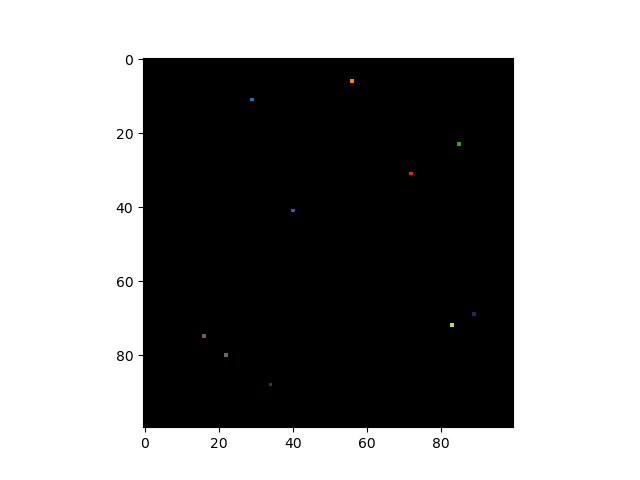

In [10]:
final_spots = cle.exclude_labels_with_map_values_out_of_range(
    binary_image,
    labeled_spots,
    minimum_value_range=1,
    maximum_value_range=1
)
final_spots

We can then visualize the spots again using the strategy introduced above, but this time on the original image.

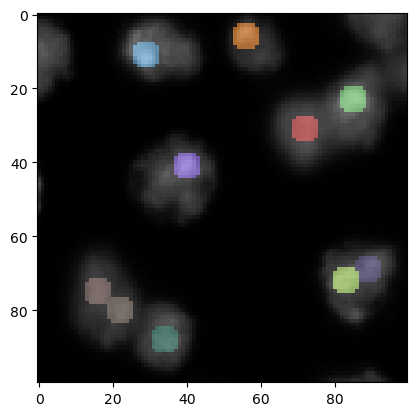

In [11]:
label_visualization2 = cle.dilate_labels(final_spots, radius=3)

cle.imshow(image, continue_drawing=True)
cle.imshow(label_visualization2, labels=True, alpha=0.5)